This notebook compares the performance of Gemello with LBM at 2 mins and 15 mins

In [1]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days


In [2]:
import nilmtk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
from nilmtk import *
import os
import nilmtk

In [5]:
st = pd.HDFStore("/Users/nipunbatra/Downloads/wiki-temp.h5")

In [6]:
all_homes_all_appliance=[26.0,
 94.0,
 370.0,
 410.0,
 545.0,
 624.0,
 1283.0,
 1334.0,
 1642.0,
 1953.0,
 2129.0,
 2156.0,
 2242.0,
 2470.0,
 2814.0,
 3367.0,
 3456.0,
 3482.0,
 3723.0,
 3967.0,
 4732.0,
 4767.0,
 5357.0,
 5371.0,
 5746.0,
 5785.0,
 5814.0,
 6072.0,
 6636.0,
 6836.0,
 6910.0,
 7016.0,
 7731.0,
 7769.0,
 7866.0,
 8317.0,
 9052.0,
 9609.0,
 9654.0,
 9922.0,
 9933.0,
 9934.0,
 9982.0]

In [7]:
st_out = pd.HDFStore("../data/output/fhmm_lbm-2-15.h5")

for home in all_homes_all_appliance[:]:
    try:
        pred = pd.read_csv("../data/output/lbm-2min/%d.csv" %home, index_col=0)
        pred.index = pd.to_datetime(pred.index)
        pred = pred['2013']
        pred = pred.resample("1M", how="sum").mul(0.000017).mul(2)
        pred.index = range(1, 13)
        pred = pred[['hvac','dw','dr','fridge','wm','light']]
        
        st_out['%d' %home] = pred
    except Exception, e:
        print e

In [8]:
lbm_accur = {}
stores  = {2:pd.HDFStore("../data/output/fhmm_lbm-2-15.h5"), 15:pd.HDFStore("../data/output/fhmm_lbm.h5")}

for freq in [2, 15]:
    lbm_accur[freq] = {}
    for appliance in ["hvac","fridge","dw","wm","light","dr"]:
        
        if appliance =="hvac":
            start, end = 5, 11
        else:
            start, end = 1, 13
        out_ap = {}
        accuracies = {}
        for home in all_homes[appliance][:]:
            out_ap[home] = {}
            pred = stores[freq]['/%d' %home][appliance]
            for month in range(start, end):
                out_ap[home][month] = {}
                gt = df.ix[home]['%s_%d' %(appliance, month)]
                out_ap[home][month]['gt'] = gt
                out_ap[home][month]['pred'] = pred.ix[month]
            a = pd.DataFrame(out_ap[home]).T
            e = (a['gt']-a['pred']).abs().div(a['gt'])*100
            accur = 100-e
            accur[accur<0] = 0
            accuracies[home] = accur
        lbm_accur[freq][appliance] = pd.DataFrame(accuracies).mean().mean()

In [9]:
appliance_name_map = {"fridge":"Fridge","hvac":"HVAC","wm":"Washing\nmachine",
                      "dr":"Dryer","dw":"Dish\nwasher","light":"Lights"}

In [10]:
%matplotlib inline
d = pd.DataFrame(lbm_accur).T

In [11]:
d = d.rename(columns=appliance_name_map)

In [12]:
d

,Dryer,Dish washer,Fridge,HVAC,Lights,Washing machine
2,21.063574,24.062129,65.982432,59.983497,39.769240,31.418768
15,5.940615,16.495110,71.822239,55.722782,10.596621,30.640745


In [13]:
d =d.T.ix[['HVAC','Fridge','Washing\nmachine','Lights','Dryer','Dish\nwasher']].T

In [14]:
d

,HVAC,Fridge,Washing machine,Lights,Dryer,Dish washer
2,59.983497,65.982432,31.418768,39.769240,21.063574,24.062129
15,55.722782,71.822239,30.640745,10.596621,5.940615,16.495110


In [15]:
d.index = ['LBM (2 min)', 'LBM (15 min)']

In [16]:
d

,HVAC,Fridge,Washing machine,Lights,Dryer,Dish washer
LBM (2 min),59.983497,65.982432,31.418768,39.769240,21.063574,24.062129
LBM (15 min),55.722782,71.822239,30.640745,10.596621,5.940615,16.495110


In [17]:
from constants import APPROACH

In [18]:
d.loc[APPROACH] = pd.Series({'Dish\nwasher': 27.333401871684234,
 'Dryer': 33.052222078385938,
 'Fridge': 68.541552745826976,
 'HVAC': 76.239355252614146,
 'Lights': 42.757293980395275,
 'Washing\nmachine': 57.272795296939734})

In [19]:
from common_functions import latexify, tableau20blind, format_axes

In [20]:
latexify(columns=1)

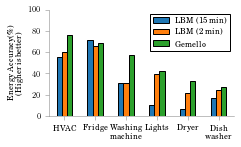

In [21]:
d.ix[['LBM (15 min)', 'LBM (2 min)', APPROACH]].T.plot(kind="bar", 
                                                       colors=tableau20blind[::2]
                                                       , rot=0)
format_axes(plt.gca())
plt.ylim((0,100))
plt.ylabel("Energy Accuracy(\%)\n(Higher is better)");
plt.tight_layout()
plt.savefig("../results/lbm-time.pdf",bbox_inches="tight")
plt.savefig("../results/lbm-time.png",bbox_inches="tight")